In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm

df = pd.read_csv("data.csv")

df = df[df["CONSENT"] == "Yes, I accept"]

right_answers = {
    "photo1": "Real photo",
    "photo2": "AI generated",
    "photo3": "AI generated",
    "photo4": "AI generated",
    "photo5": "Left Picture",
    "photo6": "Right Picture",
    "photo7": "Right Picture"
}

# NEW COLUMN

df["RIGHT ANSWERS"] = df[list(right_answers.keys())].eq(pd.Series(right_answers)).sum(axis=1)
database = df[["AGE", "SOCIAL MEDIA USAGE", "MAIN SOCIAL MEDIA", "CONFIDENCE", "RIGHT ANSWERS"]]

database.head()



,AGE,SOCIAL MEDIA USAGE,MAIN SOCIAL MEDIA,CONFIDENCE,RIGHT ANSWERS
0,20,1-3 hours,Instagram,4,5
1,20,3-5 hours,TikTok,4,6
2,20,1-3 hours,TikTok,3,5
3,18,1-3 hours,TikTok,5,5
4,21,3-5 hours,Instagram,3,6


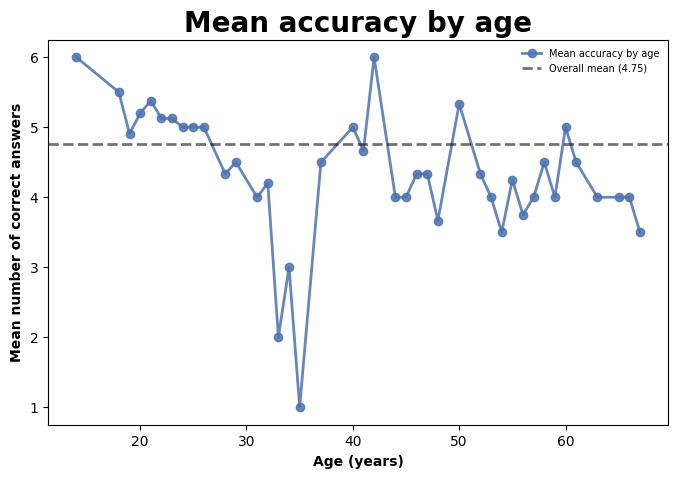

In [11]:
# overall accuracy vs age

df_1 = database.copy()

mean_per_age = df_1.groupby("AGE")["RIGHT ANSWERS"].mean()
overall_mean = df_1["RIGHT ANSWERS"].mean()

plt.figure(figsize=(8,5))
plt.plot(mean_per_age.index, mean_per_age.values, marker="o", linewidth=2,  color="#4C72B0", alpha=0.85, label="Mean accuracy by age")
plt.axhline(overall_mean, linestyle="--", linewidth=2, color="black", label=f"Overall mean ({overall_mean:.2f})", alpha=0.55)

plt.xlabel("Age (years)", fontweight="bold")
plt.ylabel("Mean number of correct answers", fontweight="bold")
plt.title("Mean accuracy by age", fontweight="bold", fontsize=20)
plt.legend(fontsize=7, frameon=False)
plt.show()

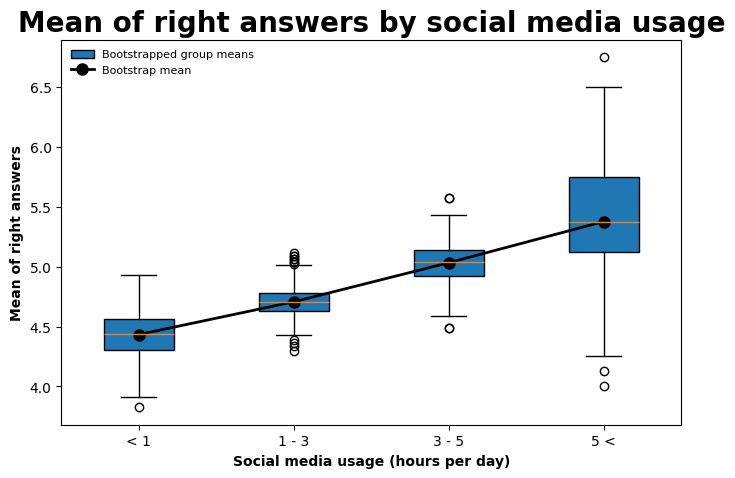

In [10]:
# overall accuracy vs social med usage
# use bootstrapping bcs the groups are uneven

# please use the following database variable in this part, so u do not interfere with the other parts
df_2 = database.copy()

order = ["Less than 1h", "1-3 hours", "3-5 hours", "5+ hours"]

bs = []
mean_per_cat = []

for group in order:
    data = df_2[df_2["SOCIAL MEDIA USAGE"] == group]["RIGHT ANSWERS"]
    means = [data.sample(n=len(data), replace=True).mean() for _ in range(1000)]
    
    bs.append(means)
    mean_per_cat.append(np.mean(means))



# plot
orders_for_plot = ["< 1", "1 - 3", "3 - 5", "5 <"]
plt.figure(figsize=(8,5))

plt.boxplot(bs, tick_labels=orders_for_plot, patch_artist=True, label="Bootstrapped group means")

for box in plt.gca().artists:
    box.set_facecolor("#4C72B0")
    
plt.plot(range(1, 5), mean_per_cat, 'ko-', linewidth=2, markersize=8, label="Bootstrap mean")

plt.xlabel("Social media usage (hours per day)", fontweight='bold')
plt.ylabel("Mean of right answers", fontweight='bold')
plt.title("Mean of right answers by social media usage", fontweight='bold', fontsize=20)
plt.legend(fontsize=8, frameon=False, loc="upper left")
plt.show()

In [4]:
# generalized linear model, (age and usage) vs right answers (correct, incorrect)

# please use the following database variable in this part, so u do not interfere with the other parts
df_3 = database.copy()

names_mapped_to_num = {"Less than 1h": 0.5, "1-3 hours": 2, "3-5 hours": 4, "5+ hours": 6}

df_3["USAGE_HOURS"] = df_3["SOCIAL MEDIA USAGE"].map(names_mapped_to_num)

glm = sm.GLM(np.column_stack([df_3["RIGHT ANSWERS"], len(right_answers) - df_3["RIGHT ANSWERS"]]), # target
             sm.add_constant(df_3[["AGE", "USAGE_HOURS"]]), # X
             family=sm.families.Binomial()).fit()

print(glm.summary())

# meaningful col: AGE            -0.0173      0.004     -4.231      0.000      -0.025      -0.009
# -0.0173 is a coefficient that explains how the accuracy behaves as the age grows, rather than showing only the correlation
# and P < 0.001 means it is a meaningful result, confirming the 1st graph
# unfortunately, no meaningful result for usage hour

                 Generalized Linear Model Regression Results                  
Dep. Variable:           ['y1', 'y2']   No. Observations:                  200
Model:                            GLM   Df Residuals:                      197
Model Family:                Binomial   Df Model:                            2
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -301.05
Date:                Sat, 17 Jan 2026   Deviance:                       175.11
Time:                        17:42:35   Pearson chi2:                     160.
No. Iterations:                     4   Pseudo R-squ. (CS):             0.1214
Covariance Type:            nonrobust                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const           1.3026      0.222      5.863      

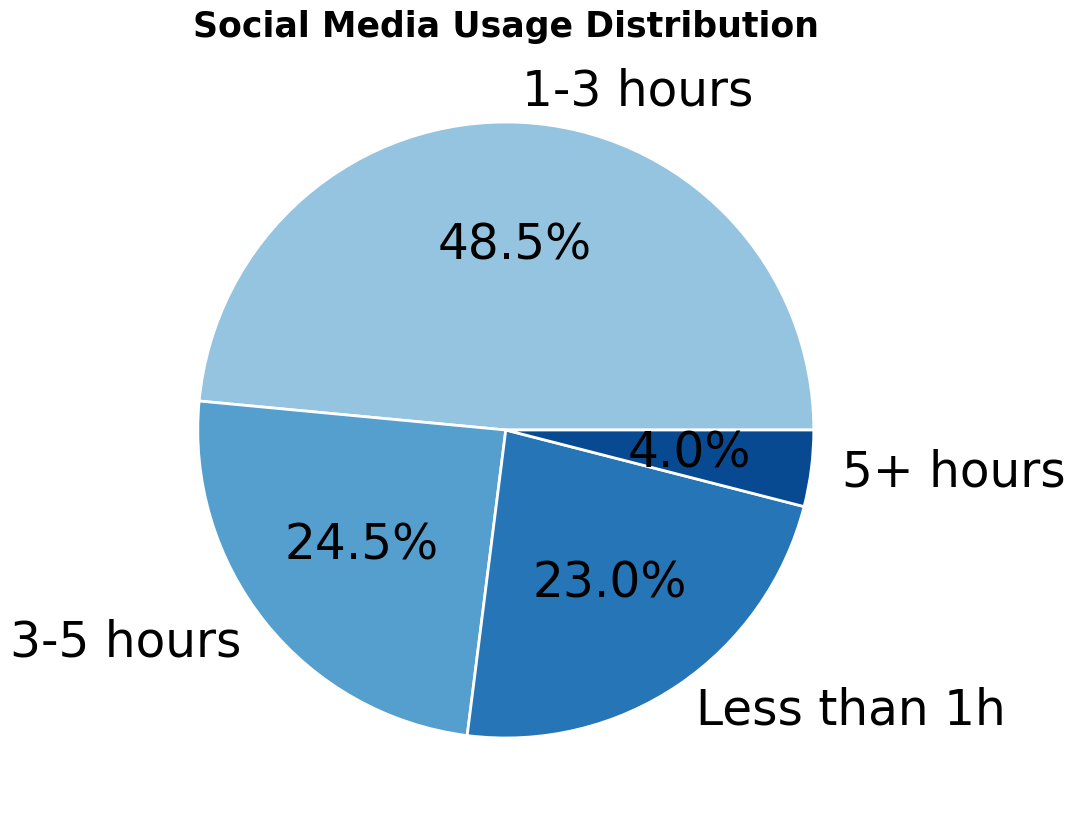

In [9]:
usage_counts = df["SOCIAL MEDIA USAGE"].value_counts()
colors = plt.cm.Blues(np.linspace(0.4, 0.9, len(usage_counts)))

plt.figure(figsize=(10, 10)) 

plt.pie(usage_counts, 
        labels=usage_counts.index, 
        autopct='%1.1f%%',          
        colors=colors,              
        textprops={'fontsize': 35, 'color': 'black'}, 
        wedgeprops={"edgecolor": "white", 'linewidth': 2} 
       )
plt.title("Social Media Usage Distribution",fontweight="bold", fontsize=25)


plt.show()

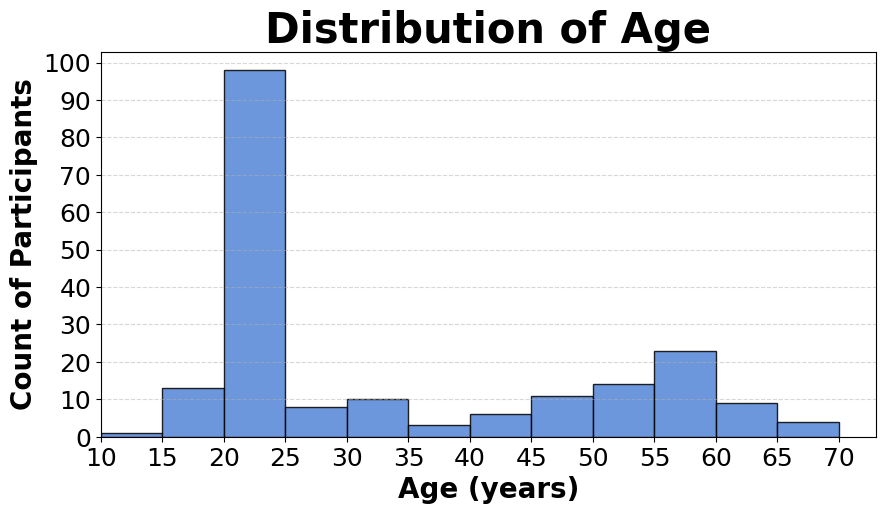

In [13]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.ticker import MultipleLocator

min_age = int(database["AGE"].min())
max_age = int(database["AGE"].max())

start = (min_age // 5) * 5
bins = np.arange(start, max_age + 6, 5) #[15, 20, 25, 30, ... 70]

plt.figure(figsize=(10, 5))

plt.hist(database["AGE"], bins=bins, color="#5385D6", alpha=0.85, edgecolor="black")

plt.xlabel("Age (years)", fontweight="bold", fontsize=20)
plt.ylabel("Count of Participants", fontweight="bold", fontsize=20)
plt.title("Distribution of Age", fontweight="bold", fontsize=30)
plt.tick_params(axis='both', which='major', labelsize=18)

ax = plt.gca()
ax.xaxis.set_major_locator(MultipleLocator(5))
ax.yaxis.set_major_locator(MultipleLocator(10))

plt.xlim(left=start) 
plt.grid(axis='y', alpha=0.5, linestyle='--')

plt.show()

C:\Users\Usuario\AppData\Local\Temp\ipykernel_23412\2059617472.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  database['Age Group'] = pd.cut(database['AGE'], bins=bins, labels=labels)
C:\Users\Usuario\AppData\Local\Temp\ipykernel_23412\2059617472.py:12: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = database.groupby('Age Group')['RIGHT ANSWERS'].agg(['mean', 'sem'])


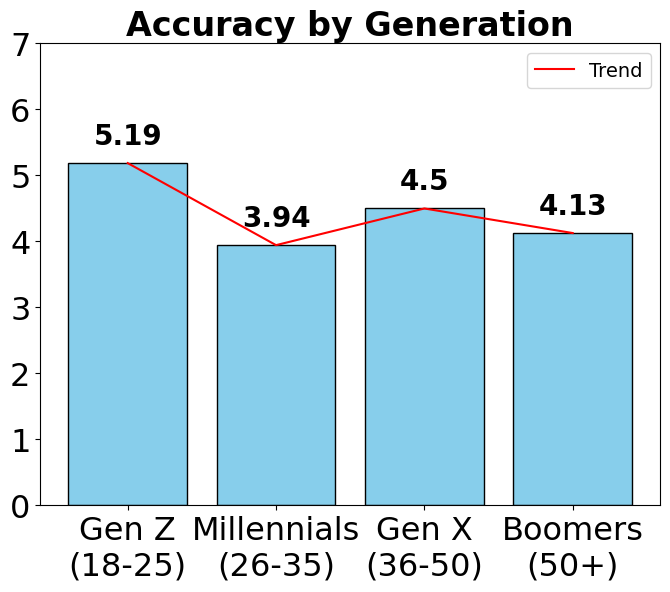

In [15]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np


plt.figure(figsize=(8, 6))

bins = [17, 25, 35, 50, 100]
labels = ['Gen Z\n(18-25)', 'Millennials\n(26-35)', 'Gen X\n(36-50)', 'Boomers\n(50+)']
database['Age Group'] = pd.cut(database['AGE'], bins=bins, labels=labels)

grouped = database.groupby('Age Group')['RIGHT ANSWERS'].agg(['mean', 'sem'])

bars = plt.bar(grouped.index, grouped['mean'],  capsize=10, color='skyblue', edgecolor='black')

plt.plot(grouped.index, grouped['mean'], color='red', label='Trend')

plt.title('Accuracy by Generation', fontsize=24, fontweight='bold')
plt.ylim(0, 7)
plt.legend(fontsize=14)
plt.tick_params(axis='both', which='major', labelsize=23)


for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.2, round(yval, 2), ha='center', va='bottom', fontweight='bold', fontsize=20)

plt.show()